In [1]:
import torch as pt
from torch import nn
import torch.nn.functional as F

from pyconll import iter_from_file

from tokenizer import train_mopiece, MOPiece

import regex as re

from word_autoencoder import WordEncoder, WordDecoder
from dependency_parser import DependencyParser
from moplm import Transformer, MOPLM

from tqdm.notebook import trange, tqdm

device = ('cuda' if pt.cuda.is_available() else 'mps' if pt.backends.mps.is_available() else 'cpu')

with open(r'data\morphynet\prefixes.csv') as file:
    prefixes = [s[:-1] for s in file.readlines()[1:]]
with open(r'data\morphynet\suffixes.csv') as file:
    suffixes = [s[:-1] for s in file.readlines()[1:]]

#### Phase 1

In [3]:
def use_tree(tree, reg):
    reg_words = [word for word in reg.split(tree.text) if word != ' ' and word != '']
    tree_words = []
    for word in tree:
        if word._form is not None and word.head is not None:
            word_s = reg.sub('', word._form)
            if word_s:
                tree_words.append(word_s)
    if reg_words == tree_words:
        return True
    if len(reg_words) == len(tree_words):
        nts_match = True
        for r, t in zip(reg_words, tree_words):
            if r != t and r[-1] != 'n' and t != 'nt':
                nts_match = False
                break
        return nts_match
    
    
def train_tree_tokenizer(directory_path, filepath, prefixes, suffixes, spm_vocab_size: int, spm_model_type: str='bpe', min_stem: int=3):
    words = []
    reg = re.compile(r'[^\p{L}\p{M}\p{N}\s]+|\s')
    for tree in iter_from_file(filepath):
        if use_tree(tree, reg):
            for word in tree:
                if word._form is not None and word.head is not None:
                    word_s = reg.sub('', word._form)
                    if word_s:
                        words.append(word_s)
    train_mopiece(directory_path, words, prefixes, suffixes, spm_vocab_size, spm_model_type, min_stem, False)


class TreeDataset(pt.utils.data.Dataset):
    def __init__(self, filepath, mopiece):
        reg = re.compile(r'[^\p{L}\p{M}\p{N}\s]+|\s')
        self.labels = []
        self.prefix_ids = []
        self.spm_ids = []
        self.suffix_ids = []
        bos_id = mopiece.bos_id()
        eos_id = mopiece.eos_id()
        for tree in iter_from_file(filepath):
            if use_tree(tree, reg):
                labels = []
                prefix_ids = []
                spm_ids = []
                suffix_ids = []
                skipped_ids = []
                for word in tree:
                    if word._form is not None and word.head is not None:
                        word_s = reg.sub('', word._form)
                        if word_s:
                            word_prefix_ids, word_spm_ids, word_suffix_ids = mopiece.encode_word(word_s)
                            prefix_ids.append([bos_id] + word_prefix_ids + [eos_id])
                            spm_ids.append([bos_id] + word_spm_ids + [eos_id])
                            suffix_ids.append([bos_id] + word_suffix_ids + [eos_id])
                            labels.append(int(word.head))
                            continue
                    if '-' not in word.id and '.' not in word.id:
                        skipped_ids.append(int(word.id))
                self.prefix_ids.append(prefix_ids)
                self.spm_ids.append(spm_ids)
                self.suffix_ids.append(suffix_ids)
                for i, label in enumerate(labels):
                    labels[i] -= sum([label >= j for j in skipped_ids])
                self.labels.append(pt.tensor(labels, dtype=pt.long))
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.prefix_ids[index], self.spm_ids[index], self.suffix_ids[index], self.labels[index]

In [ ]:
train_tree_tokenizer('____tree_tokenizer', 'data/treebank/en_ewt-ud-train.conllu', prefixes, suffixes, 3000)

In [ ]:
tree_mopiece = MOPiece('____tree_tokenizer')
train_dset = TreeDataset(r'data\treebank\en_ewt-ud-train.conllu', tree_mopiece)
test_dset = TreeDataset(r'data\treebank\en_ewt-ud-test.conllu', tree_mopiece)

In [ ]:
pad_id = tree_mopiece.pad_id()

def collate_fn(batch):
    def handle_component(i):
        max_len = max_sublen = 0
        for tup in batch:
            seq = tup[i]
            max_len = max(max_len, len(seq))
            for subseq in seq:
                max_sublen = max(max_sublen, len(subseq))
        tensor = []
        for tup in batch:
            seq = tup[i]
            tensor_seq = []
            for subseq in seq:
                tensor_seq.append(subseq + [pad_id] * (max_sublen - len(subseq)))
            for _ in range(max_len - len(seq)):
                tensor_seq.append([pad_id] * max_sublen)
            tensor.append(tensor_seq)
        return pt.tensor(tensor, dtype=pt.long)

    return handle_component(0), handle_component(1), handle_component(2), nn.utils.rnn.pad_sequence([labels for prefix, spm, suffix, labels in batch], batch_first=True, padding_value=-1)

In [5]:
encoder = WordEncoder(tree_mopiece.vocab_size(), tree_mopiece.pad_id(), 256, ffn_hidden_dim=512, expansion_factor=4, spm_layers=6, suffix_depth=4, prefix_depth=4).to(device)
parser = DependencyParser(256, dropout=.1).to(device)

In [ ]:
train_loader = pt.utils.data.DataLoader(train_dset, batch_size=8, shuffle=True, collate_fn=collate_fn, pin_memory=True, drop_last=True)
test_loader = pt.utils.data.DataLoader(test_dset, batch_size=8, collate_fn=collate_fn, pin_memory=True, drop_last=True)

criterion = nn.CrossEntropyLoss(ignore_index=-1, label_smoothing=.1)

epochs = 30
accumulate_grad = 2

optim = pt.optim.AdamW([
    {"params": encoder.parameters()},
    {"params": parser.parameters()}
], weight_decay=0.01, lr=3e-4)
lr_scheduler = pt.optim.lr_scheduler.CosineAnnealingLR(optim, epochs)

encoder.train()
parser.train()

train_losses = []
test_losses = []
test_accuracies = []
for epoch in (pbar := trange(epochs, desc='Epoch')):
    train_loss_sum = 0
    optim.zero_grad()
    for i, (prefix_ids, spm_ids, suffix_ids, labels) in enumerate(tqdm(train_loader, desc='Training', leave=False)):
        prefix_ids = prefix_ids.to(device)
        spm_ids = spm_ids.to(device)
        suffix_ids = suffix_ids.to(device)
        labels = labels.to(device)
        
        embeddings = encoder(prefix_ids, spm_ids, suffix_ids)
        logits = parser(embeddings, labels != -1)

        loss = criterion(logits.flatten(end_dim=-2), labels.flatten())
        loss.backward()

        if (i + 1) % accumulate_grad == 0:
            optim.step()
            optim.zero_grad()

        train_loss_sum += loss.item()

    train_loss = train_loss_sum / len(train_loader)
    train_losses.append(train_loss)
    with pt.no_grad():
        test_loss_sum = 0.
        hits = 0
        total = 0
        for prefix_ids, spm_ids, suffix_ids, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            prefix_ids = prefix_ids.to(device)
            spm_ids = spm_ids.to(device)
            suffix_ids = suffix_ids.to(device)
            labels = labels.to(device)
            
            embeddings = encoder(prefix_ids, spm_ids, suffix_ids)
            logits = parser(embeddings, labels != -1).flatten(end_dim=-2)

            logits = logits.flatten(end_dim=-2)
            labels = labels.flatten()

            test_loss_sum += criterion(logits, labels).item()
            hits += pt.sum(logits.argmax(-1) == labels).item()
            total += pt.sum(labels != -1).item()

    test_loss = test_loss_sum / len(test_loader)
    test_losses.append(test_loss)
    test_acc = hits / total
    test_accuracies.append(test_acc)
    pbar.set_postfix_str(f'train loss: {train_loss:.2f}, test loss: {test_loss:.2f}, test accuracy: {test_acc*100:.2f}%')

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

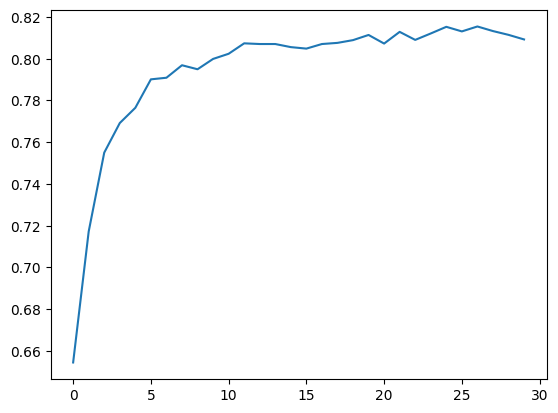

In [7]:
import matplotlib.pyplot as plt

plt.plot(test_accuracies)

In [9]:
pt.save(encoder.state_dict(), '____tree_encoder.pt')
pt.save(parser.state_dict(), '____tree_parser.pt')

In [6]:
encoder.load_state_dict(pt.load('____tree_encoder.pt', weights_only=True))
parser.load_state_dict(pt.load('____tree_parser.pt', weights_only=True))

<All keys matched successfully>

In [23]:
with pt.no_grad():
    encoder.eval()
    parser.eval()
    bos_id, eos_id = tree_mopiece.bos_id(), tree_mopiece.eos_id()
    input_sentence = input()
    words = input_sentence.split()
    print(words)
    embeddings = []
    for word in words:
        prefix_ids, spm_ids, suffix_ids = map(lambda x: [bos_id] + x + [eos_id], tree_mopiece.encode_word(word))
        embedding = encoder(pt.tensor(prefix_ids, dtype=pt.long, device=device), pt.tensor(spm_ids, dtype=pt.long, device=device), pt.tensor(suffix_ids, dtype=pt.long, device=device))
        embeddings.append(embedding.unsqueeze(0))
    heads = parser.inference(pt.cat(embeddings, dim=-2))
    root_words = ['ROOT'] + words
    for i, head in enumerate(heads):
        words[i] += f'->{root_words[head]}'
    print(words)

['a', 'pretty', 'horse', 'landed', 'on', 'the', 'green', 'grass']
['a->horse', 'pretty->horse', 'horse->landed', 'landed->ROOT', 'on->grass', 'the->grass', 'green->grass', 'grass->landed']


#### Phase 2

In [2]:
tree_mopiece = MOPiece('____tree_tokenizer')
encoder = WordEncoder(tree_mopiece.vocab_size(), tree_mopiece.pad_id(), 256, ffn_hidden_dim=512, expansion_factor=4, spm_layers=6, suffix_depth=4, prefix_depth=4).to(device)
parser = DependencyParser(256, dropout=.1).to(device)
encoder.load_state_dict(pt.load('____tree_encoder.pt', weights_only=True))
parser.load_state_dict(pt.load('____tree_parser.pt', weights_only=True))

<All keys matched successfully>

In [3]:
from datasets import load_dataset

ds = load_dataset("lucadiliello/bookcorpusopen")

In [37]:
from random import shuffle
k = 1000
def texts():
    idxs = list(range(len(ds['train'])))
    shuffle(idxs)
    for i in idxs[:k]:
        yield ds['train'][i]['text']
train_mopiece('____bookcorpus_tokenizer', texts(), prefixes, suffixes, 10000, filepaths=False)

In [4]:
mopiece = MOPiece('____bookcorpus_tokenizer')

In [5]:
from random import randrange

class BookCorpusInfiniteDataloader:
    def __init__(self, dset, chunk_size_min=64, chunk_size_max=256):
        self.dset = dset
        self.chunk_size_min = chunk_size_min
        self.chunk_size_max = chunk_size_max
        self.reg = re.compile(r'[^\p{L}\p{M}\p{N}\s]+|\s')

    def __iter__(self):
        return self
    
    def __next__(self):
        while True:
            try:
                idx = randrange(len(self.dset))
                encoder_chunk_size = randrange(self.chunk_size_min, self.chunk_size_max + 1)
                decoder_chunk_size = randrange(self.chunk_size_min, self.chunk_size_max + 1)
                total_chunk_size = encoder_chunk_size + decoder_chunk_size
                text = self.dset[idx]['text']
                max_idx = len(text) - total_chunk_size
                if max_idx < 0:
                    continue
                start_idx = randrange(max_idx + 1)
                middle_idx = start_idx + encoder_chunk_size
                end_idx = middle_idx + decoder_chunk_size
                m = self.reg.search(text, start_idx, middle_idx)
                if m is None:
                    continue
                start_idx = m.end()
                m = self.reg.search(text, middle_idx, end_idx)
                if m is None:
                    continue
                middle_idx = m.end()
                m = self.reg.search(text, end_idx)
                if m is None:
                    continue
                end_idx = m.end()
                if start_idx == middle_idx or middle_idx == end_idx:
                    continue
                return text[start_idx:middle_idx], text[middle_idx:end_idx]
            except:
                pass


In [6]:
embedding_dim = 512

word_encoder = WordEncoder(mopiece.vocab_size(), mopiece.pad_id(), embedding_dim, ffn_hidden_dim=embedding_dim * 2, expansion_factor=4, spm_layers=6, suffix_depth=4, prefix_depth=4).to(device)
word_decoder = WordDecoder(mopiece.vocab_size(), mopiece.pad_id(), mopiece.bos_id(), mopiece.eos_id(), embedding_dim, num_layers=8, expansion_factor=2).to(device)
transformer = Transformer(embedding_dim).to(device)
moplm = MOPLM(word_encoder, word_decoder, transformer).to(device)

In [ ]:
bos_id, eos_id, pad_id = mopiece.bos_id(), mopiece.eos_id(), mopiece.pad_id()

xent = nn.CrossEntropyLoss(ignore_index=pad_id, label_smoothing=.1)
criterion = lambda logits, labels: xent(logits.flatten(end_dim=-2), labels.flatten())

loader = BookCorpusInfiniteDataloader(ds['train'])

epoch_steps = 100
gradient_accumulation = 2

optim = pt.optim.AdamW(moplm.parameters(), weight_decay=0.01, lr=3e-4)
lr_scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=.5, patience=10, cooldown=10)

moplm.train()

reg = re.compile(r'([^\p{L}\p{M}\p{N}\s]+|\s)')

losses = []
step = 0
pbar = tqdm(desc='Epochs')
epoch_pbar = tqdm(desc='Training', total=epoch_steps, leave=False)
epoch_loss_sum = 0.
optim.zero_grad()
for encoder_text, decoder_text in loader:

    context_prefix_ids, context_spm_ids, context_suffix_ids = map(lambda x: [[bos_id] + seq + [eos_id] for seq in x[0]], mopiece.encode([encoder_text]))
    
    tokens = []
    words = []
    word_indices = []
    idx = 0
    for word in reg.split(decoder_text):
        if word == ' ' or word == '':
            continue
        word = word.lower()
        if not reg.search(word):
            words.append(word)
            word_indices.append(idx)
        tokens.append(word)
        idx += 1

    embeddings = []
    for word in words:
        prefix_ids, spm_ids, suffix_ids = map(lambda x: [bos_id] + x + [eos_id], tree_mopiece.encode_word(word))
        embedding = encoder(pt.tensor(prefix_ids, dtype=pt.long, device=device), pt.tensor(spm_ids, dtype=pt.long, device=device), pt.tensor(suffix_ids, dtype=pt.long, device=device))
        embeddings.append(embedding.unsqueeze(0))
    heads = parser.inference(pt.cat(embeddings, dim=-2))
    word_depths = []
    for head in heads:
        depth = 0
        while head:
            head = heads[head - 1]
            depth += 1
        word_depths.append(depth)
    
    max_depth = max(word_depths) + 1
    token_depths = [max_depth] * len(tokens)
    for idx, depth in zip(word_indices, word_depths):
        token_depths[idx] = depth
    
    input_prefix_ids = [[bos_id, eos_id]]
    input_spm_ids = [[bos_id, eos_id]]
    input_suffix_ids = [[bos_id, eos_id]]
    input_depths = [max_depth + 1]
    input_is_pad = [True]
    output_prefix_ids = [[bos_id, eos_id]]
    output_spm_ids = [[bos_id, eos_id]]
    output_suffix_ids = [[bos_id, eos_id]]
    for depth, token in zip(token_depths, tokens):
        prefix_ids, spm_ids, suffix_ids = mopiece.encode_word(token)
        input_prefix_ids.append([bos_id] + prefix_ids + [eos_id])
        input_spm_ids.append([bos_id] + spm_ids + [eos_id])
        input_suffix_ids.append([bos_id] + suffix_ids + [eos_id])
        input_depths.append(depth)
        input_is_pad.append(False)
        
        for pad_depth in (depth, max_depth + 1):
            for l in (input_prefix_ids, input_spm_ids, input_suffix_ids):
                l.append([bos_id, eos_id])
            input_depths.append(pad_depth)
            input_is_pad.append(True)

        for _ in range(2):
            output_prefix_ids.append([bos_id] + prefix_ids + [eos_id])
            output_spm_ids.append([bos_id] + spm_ids + [eos_id])
            output_suffix_ids.append([bos_id] + suffix_ids + [eos_id])

        for l in (output_prefix_ids, output_spm_ids, output_suffix_ids):
            l.append([bos_id, eos_id])
    
    attn_mask = []
    for depth_i, pad_i in zip(input_depths, input_is_pad):
        attn_mask_row = []
        for depth_j, pad_j in zip(input_depths, input_is_pad):
            attn_mask_row.append((depth_i >= depth_j + (pad_i and not pad_j)) and (pad_i or not pad_j))
        attn_mask.append(attn_mask_row)
    
    attn_mask = pt.tensor(attn_mask, dtype=pt.bool, device=device)

    input_prefix_ids, input_spm_ids, input_suffix_ids, context_prefix_ids, context_spm_ids, context_suffix_ids, output_prefix_ids, output_spm_ids, output_suffix_ids = map(lambda x: nn.utils.rnn.pad_sequence([pt.tensor(seq, dtype=pt.long, device=device) for seq in x], batch_first=True, padding_value=pad_id), (input_prefix_ids, input_spm_ids, input_suffix_ids, context_prefix_ids, context_spm_ids, context_suffix_ids, output_prefix_ids, output_spm_ids, output_suffix_ids))
    
    prefix_logits, spm_logits, suffix_logits = moplm.forward(input_prefix_ids, input_spm_ids, input_suffix_ids, context_prefix_ids, context_spm_ids, context_suffix_ids, output_prefix_ids[:, :-1], output_spm_ids[:, :-1], output_suffix_ids[:, :-1], attn_mask)
    
    loss = criterion(prefix_logits, output_prefix_ids[:, 1:]) + criterion(spm_logits, output_spm_ids[:, 1:]) + criterion(suffix_logits, output_suffix_ids[:, 1:])
    loss.backward()

    epoch_loss_sum += loss.item()

    step += 1
    epoch_pbar.update()
    if step % gradient_accumulation == 0:
        optim.step()
        nn.utils.clip_grad_norm_(moplm.parameters(), 5.)
        optim.zero_grad()

    if step % epoch_steps == 0:
        epoch_loss = epoch_loss_sum / epoch_steps
        epoch_loss_sum = 0.
        lr_scheduler.step(epoch_loss)
        losses.append(epoch_loss)
        pbar.update()
        pbar.set_postfix_str(f'loss: {epoch_loss:.2f}, lr: {lr_scheduler.get_last_lr()[0]:.2e}')
        epoch_pbar.close()
        epoch_pbar = tqdm(desc='Training', total=epoch_steps, leave=False)


Epochs: 0it [00:00, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
pt.save(moplm.state_dict(), '____moplm.pt')

In [7]:
moplm.load_state_dict(pt.load('____moplm.pt', weights_only=True))

<All keys matched successfully>

In [ ]:
mopiece.decode(tuple(map(lambda x: [x], moplm.inference(*map(lambda x: x[0], mopiece.encode([input()])), max_iters=5, inference_kwargs=dict(max_len=10)))))

KeyboardInterrupt: 